In [18]:
# Install required packages (if needed)
import sys
print(f"Python version: {sys.version}")

# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running on Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# %%
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set style
plt.style.use('default')
sns.set_palette("husl")

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Running on Google Colab
TensorFlow Version: 2.19.0
Keras Version: 3.10.0


In [21]:

# ## 2. Load and Preprocess CIFAR-10 Dataset

# Load CIFAR-10
print("Loading CIFAR-10 dataset...")
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

Loading CIFAR-10 dataset...


In [22]:
# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = 10

print(f"\nOriginal dataset:")
print(f"  Training: {x_train_full.shape}, {y_train_full.shape}")
print(f"  Test: {x_test.shape}, {y_test.shape}")
print(f"  Classes: {num_classes}")
print(f"  Image shape: {x_train_full.shape[1:]}")


Original dataset:
  Training: (50000, 32, 32, 3), (50000, 1)
  Test: (10000, 32, 32, 3), (10000, 1)
  Classes: 10
  Image shape: (32, 32, 3)


In [23]:
# Split training into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full,
    test_size=0.1,
    random_state=SEED,
    stratify=y_train_full
)

print(f"\nAfter split:")
print(f"  Training: {x_train.shape}")
print(f"  Validation: {x_val.shape}")
print(f"  Test: {x_test.shape}")


After split:
  Training: (45000, 32, 32, 3)
  Validation: (5000, 32, 32, 3)
  Test: (10000, 32, 32, 3)


In [24]:
# Normalize data to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

print("\nData preprocessing complete!")
print(f"  X range: [{x_train.min():.2f}, {x_train.max():.2f}]")
print(f"  Y shape: {y_train_cat.shape}")



Data preprocessing complete!
  X range: [0.00, 1.00]
  Y shape: (45000, 10)


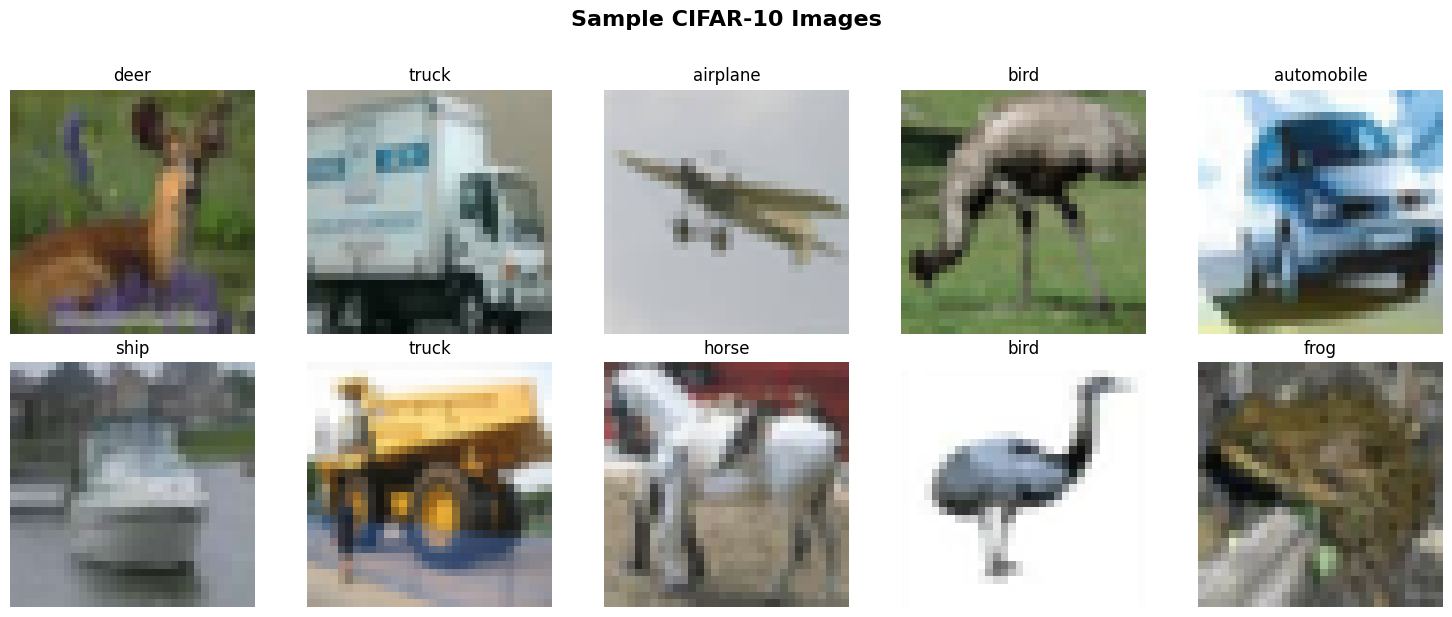

In [25]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[idx])
    axes[i].set_title(f'{class_names[y_train[idx][0]]}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Sample CIFAR-10 Images', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

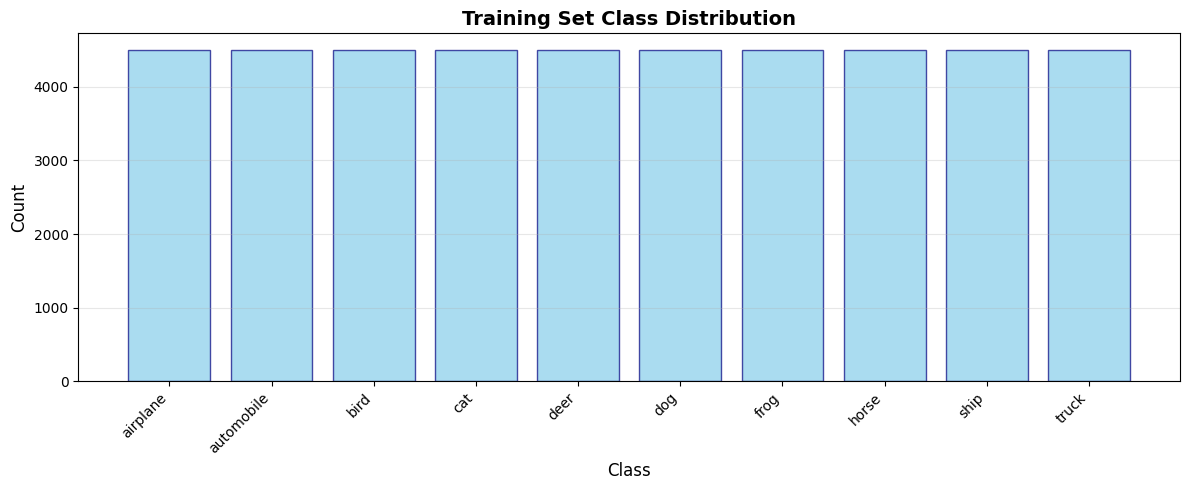


Class distribution:
  airplane    :  4500 (10.0%)
  automobile  :  4500 (10.0%)
  bird        :  4500 (10.0%)
  cat         :  4500 (10.0%)
  deer        :  4500 (10.0%)
  dog         :  4500 (10.0%)
  frog        :  4500 (10.0%)
  horse       :  4500 (10.0%)
  ship        :  4500 (10.0%)
  truck       :  4500 (10.0%)


In [26]:
# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12, 5))
plt.bar(range(num_classes), counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass distribution:")
for i, (cls, cnt) in enumerate(zip(class_names, counts)):
    print(f"  {cls:12s}: {cnt:5d} ({cnt/len(y_train)*100:.1f}%)")


In [27]:
# Standard ImageDataGenerator augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

Data augmentation configured!
  Rotation: ±15°
  Shift: ±10%
  Horizontal flip: Yes
  Zoom: ±10%


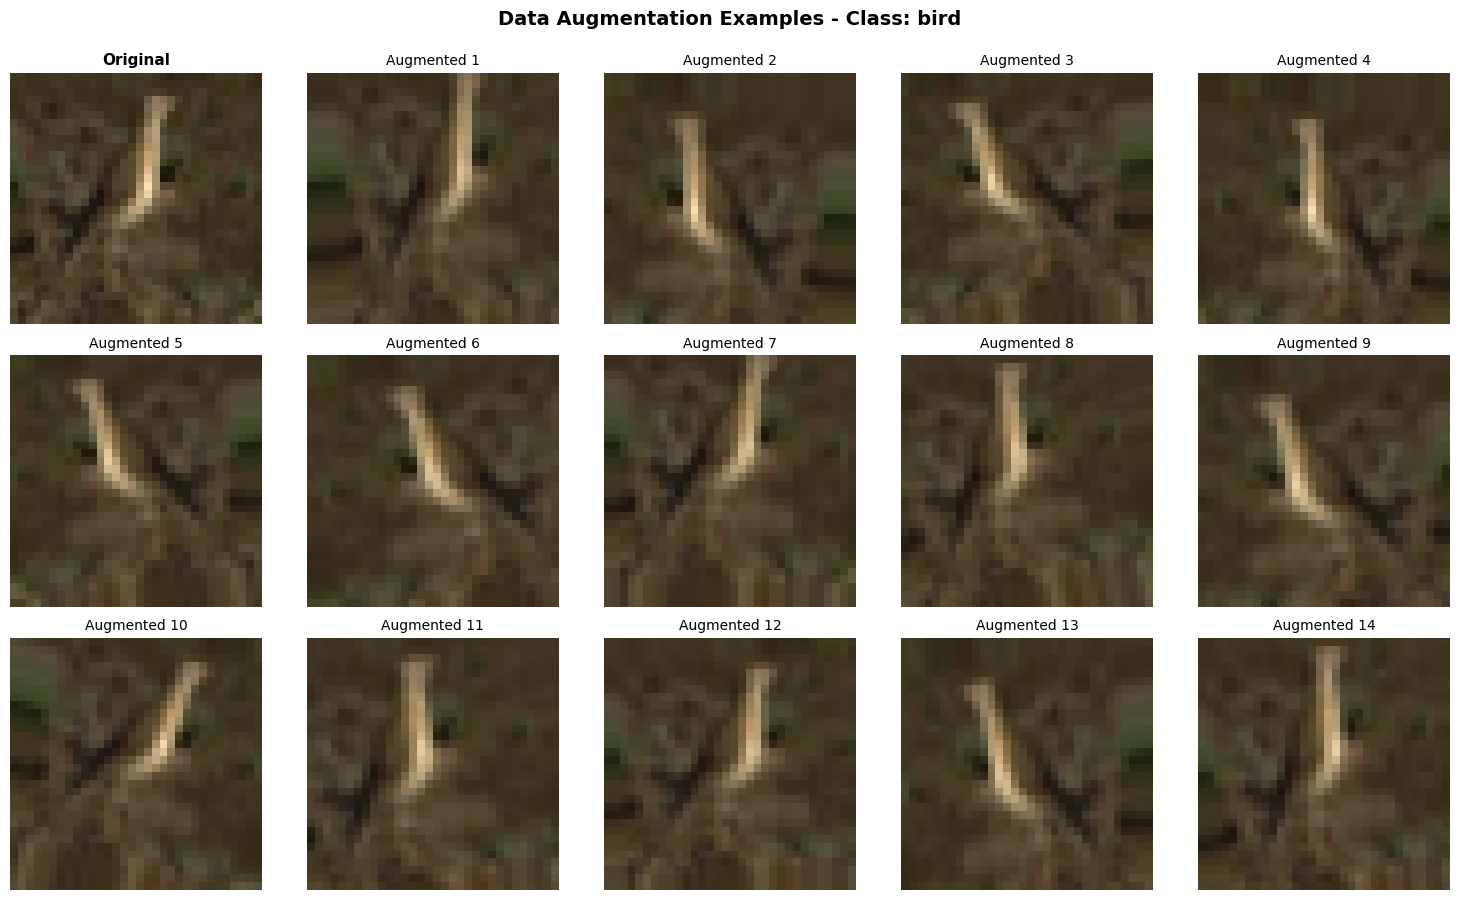

In [28]:
train_datagen.fit(x_train)

print("Data augmentation configured!")
print("  Rotation: ±15°")
print("  Shift: ±10%")
print("  Horizontal flip: Yes")
print("  Zoom: ±10%")

# %%
# Visualize augmented images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Pick one image
sample_idx = np.random.randint(0, len(x_train))
sample_img = x_train[sample_idx:sample_idx+1]
sample_label = class_names[y_train[sample_idx][0]]

# Show original
axes[0, 0].imshow(sample_img[0])
axes[0, 0].set_title('Original', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Generate augmented versions
aug_iter = train_datagen.flow(sample_img, batch_size=1)
for i in range(14):
    aug_img = next(aug_iter)[0]
    row = (i + 1) // 5
    col = (i + 1) % 5
    axes[row, col].imshow(aug_img)
    axes[row, col].set_title(f'Augmented {i+1}', fontsize=10)
    axes[row, col].axis('off')

plt.suptitle(f'Data Augmentation Examples - Class: {sample_label}',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [31]:
# ## 5. Model Architectures


class ResidualBlock(layers.Layer):
    """
    Residual Block with skip connections
    Helps combat vanishing gradients in deep networks
    """

    def __init__(self, filters, strides=1, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides

        # Main path
        self.conv1 = layers.Conv2D(filters, 3, strides=strides, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()

        self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.bn2 = layers.BatchNormalization()

        # Skip connection
        if strides != 1:
            self.shortcut = keras.Sequential([
                layers.Conv2D(filters, 1, strides=strides),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

        self.relu2 = layers.ReLU()

    def call(self, inputs, training=False):
        # Main path
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # Skip connection
        shortcut = self.shortcut(inputs)

        # Add and activate
        x = layers.add([x, shortcut])
        x = self.relu2(x)

        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "strides": self.strides,
        })
        return config

print("✓ ResidualBlock class defined")

✓ ResidualBlock class defined


In [32]:
# ### 5.2. Custom ResNet Model (with Residual Blocks) - BONUS

# %%
def build_custom_resnet(input_shape=(32, 32, 3), num_classes=10):
    """
    Custom ResNet-style CNN with Residual Blocks

    Architecture:
    - Initial Conv + BN + ReLU
    - 3 Residual Block stages (64, 128, 256 filters)
    - Global Average Pooling
    - Dense layer with Dropout
    - Softmax output

    Meets ALL requirements + Residual Blocks bonus
    """
    inputs = layers.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(64, 3, padding='same', name='initial_conv')(inputs)
    x = layers.BatchNormalization(name='initial_bn')(x)
    x = layers.ReLU(name='initial_relu')(x)

    # Stage 1: 2 Residual Blocks (64 filters)
    x = ResidualBlock(64, name='res_block_1a')(x)
    x = ResidualBlock(64, name='res_block_1b')(x)
    x = layers.MaxPooling2D(2, name='pool_1')(x)
    x = layers.Dropout(0.2, name='dropout_1')(x)

    # Stage 2: 2 Residual Blocks (128 filters)
    x = ResidualBlock(128, strides=2, name='res_block_2a')(x)
    x = ResidualBlock(128, name='res_block_2b')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)

    # Stage 3: 2 Residual Blocks (256 filters)
    x = ResidualBlock(256, strides=2, name='res_block_3a')(x)
    x = ResidualBlock(256, name='res_block_3b')(x)
    x = layers.Dropout(0.4, name='dropout_3')(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Dense layers
    x = layers.Dense(512, name='dense_1')(x)
    x = layers.BatchNormalization(name='dense_bn')(x)
    x = layers.ReLU(name='dense_relu')(x)
    x = layers.Dropout(0.5, name='dropout_final')(x)

    # Output layer with softmax
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='Custom_ResNet')

    return model

# Build and display model
model_resnet = build_custom_resnet()
print("\n" + "="*70)
print("CUSTOM RESNET MODEL (with Residual Blocks)")
print("="*70)
model_resnet.summary()


CUSTOM RESNET MODEL (with Residual Blocks)


Model: "Custom_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ initial_conv (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ initial_bn (BatchNormalization) │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ initial_relu (ReLU)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_1a (ResidualBlock)    │ (None, 32, 32, 64)     │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_1b (ResidualBlock)    │ (None, 32, 32, 64)     │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_2a (ResidualBlock)    │ (None, 8, 8, 128)      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_2b (ResidualBlock)    │ (None, 8, 8, 128)      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_3a (ResidualBlock)    │ (None, 4, 4, 256)      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_3b (ResidualBlock)    │ (None, 4, 4, 256)      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_bn (BatchNormalization)   │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (ReLU)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,920,586 (11.14 MB)

 Trainable params: 2,915,082 (11.12 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [33]:
# ### 5.3. Standard CNN Model (meets all basic requirements)

# %%
def build_standard_cnn(input_shape=(32, 32, 3), num_classes=10):
    """
    Standard CNN meeting ALL basic requirements:
    ✓ 3+ convolutional layers (6 total)
    ✓ ReLU activation functions
    ✓ MaxPooling layers (3)
    ✓ Batch Normalization (6 layers)
    ✓ Dropout regularization (4 layers)
    ✓ Global Average Pooling
    ✓ Softmax output matching num_classes
    """
    model = models.Sequential([
        # Block 1 - Conv layers 1 & 2
        layers.Conv2D(64, 3, padding='same', activation='relu',
                     input_shape=input_shape, name='conv1_1'),
        layers.BatchNormalization(name='bn1_1'),
        layers.Conv2D(64, 3, padding='same', activation='relu', name='conv1_2'),
        layers.BatchNormalization(name='bn1_2'),
        layers.MaxPooling2D(2, name='pool1'),
        layers.Dropout(0.25, name='dropout1'),

        # Block 2 - Conv layers 3 & 4
        layers.Conv2D(128, 3, padding='same', activation='relu', name='conv2_1'),
        layers.BatchNormalization(name='bn2_1'),
        layers.Conv2D(128, 3, padding='same', activation='relu', name='conv2_2'),
        layers.BatchNormalization(name='bn2_2'),
        layers.MaxPooling2D(2, name='pool2'),
        layers.Dropout(0.3, name='dropout2'),

        # Block 3 - Conv layers 5 & 6
        layers.Conv2D(256, 3, padding='same', activation='relu', name='conv3_1'),
        layers.BatchNormalization(name='bn3_1'),
        layers.Conv2D(256, 3, padding='same', activation='relu', name='conv3_2'),
        layers.BatchNormalization(name='bn3_2'),
        layers.MaxPooling2D(2, name='pool3'),
        layers.Dropout(0.4, name='dropout3'),

        # Global Average Pooling
        layers.GlobalAveragePooling2D(name='global_avg_pool'),

        # Dense layer
        layers.Dense(512, activation='relu', name='dense'),
        layers.BatchNormalization(name='bn_dense'),
        layers.Dropout(0.5, name='dropout_dense'),

        # Output layer with softmax
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='Standard_CNN')

    return model

# Build and display model
model_standard = build_standard_cnn()
print("\n" + "="*70)
print("STANDARD CNN MODEL (meets all basic requirements)")
print("="*70)
model_standard.summary()



STANDARD CNN MODEL (meets all basic requirements)


Model: "Standard_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense (BatchNormalization)   │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,287,754 (4.91 MB)

 Trainable params: 1,284,938 (4.90 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [34]:
# ### 5.4. Transfer Learning Models - BONUS

# %%
def build_transfer_learning_model(base_model_name='EfficientNetB0',
                                  input_shape=(32, 32, 3),
                                  num_classes=10,
                                  trainable_base=False):
    """
    Transfer Learning with pre-trained models
    Supports: ResNet50, EfficientNetB0, MobileNetV2
    """
    # Load base model
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model: {base_model_name}")

    # Freeze/unfreeze base model
    base_model.trainable = trainable_base

    # Build full model
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs,
                        name=f'Transfer_{base_model_name}')

    return model, base_model

# Example: Build EfficientNetB0
model_transfer, base_model_transfer = build_transfer_learning_model('EfficientNetB0')
print("\n" + "="*70)
print("TRANSFER LEARNING MODEL (EfficientNetB0)")
print("="*70)
print(f"Base model: EfficientNetB0")
print(f"Base model trainable: {base_model_transfer.trainable}")
print(f"Total parameters: {model_transfer.count_params():,}")
model_transfer.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

TRANSFER LEARNING MODEL (EfficientNetB0)
Base model: EfficientNetB0
Base model trainable: False
Total parameters: 4,386,221


Model: "Transfer_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1, 1, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,221 (16.73 MB)

 Trainable params: 333,578 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [35]:
# ## 6. Custom Loss Functions - BONUS

# %%
class FocalLoss(keras.losses.Loss):
    """
    Focal Loss for handling class imbalance
    Paper: "Focal Loss for Dense Object Detection" (Lin et al.)

    Focuses training on hard examples by down-weighting easy examples
    """

    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Clip to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate focal loss
        focal_loss = self.alpha * tf.pow(1 - y_pred, self.gamma) * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def get_config(self):
        config = super().get_config()
        config.update({"alpha": self.alpha, "gamma": self.gamma})
        return config

class LabelSmoothingLoss(keras.losses.Loss):
    """
    Label Smoothing Loss to prevent overconfidence
    Replaces hard 0/1 labels with soft probabilities
    """

    def __init__(self, smoothing=0.1, **kwargs):
        super(LabelSmoothingLoss, self).__init__(**kwargs)
        self.smoothing = smoothing

    def call(self, y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true_smooth = y_true * (1 - self.smoothing) + self.smoothing / num_classes

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        loss = -tf.reduce_sum(y_true_smooth * tf.math.log(y_pred), axis=-1)

        return tf.reduce_mean(loss)

    def get_config(self):
        config = super().get_config()
        config.update({"smoothing": self.smoothing})
        return config

print("✓ Custom loss functions defined:")
print("  - Focal Loss (for class imbalance)")
print("  - Label Smoothing Loss (prevents overconfidence)")

✓ Custom loss functions defined:
  - Focal Loss (for class imbalance)
  - Label Smoothing Loss (prevents overconfidence)


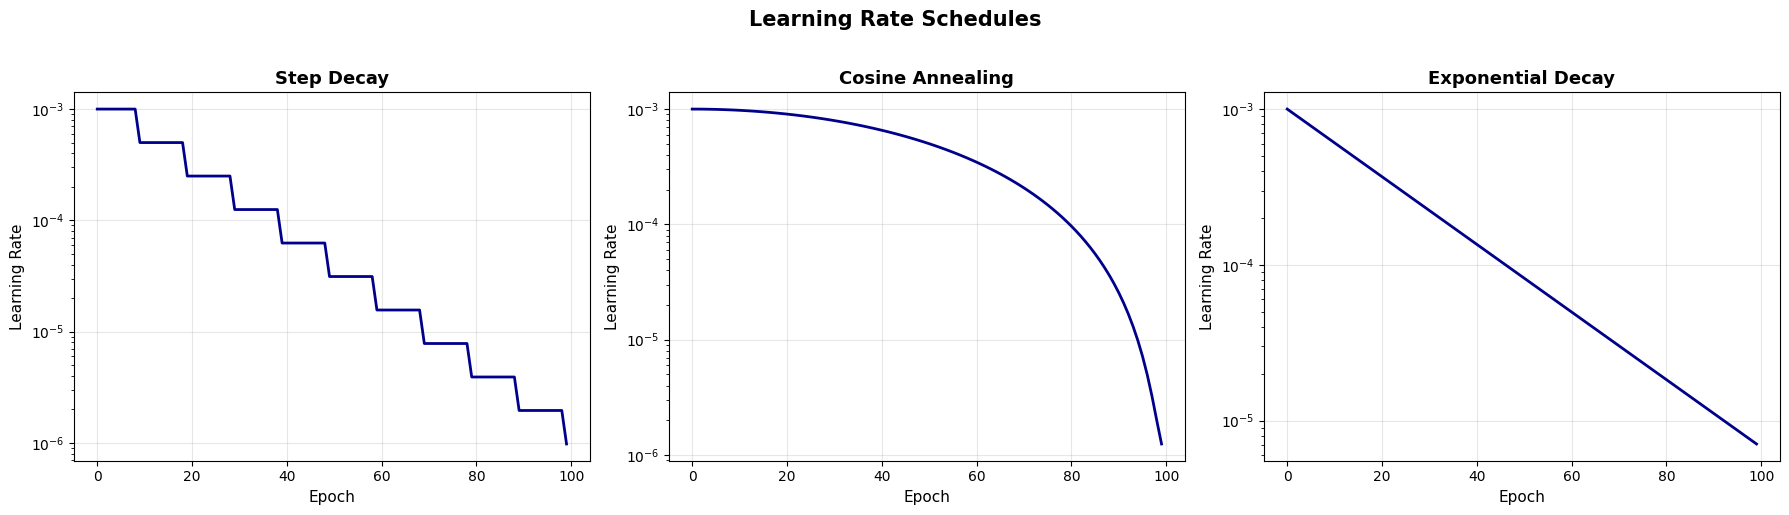

✓ Learning rate scheduling functions defined


In [36]:
# ## 7. Learning Rate Scheduling - BONUS

# %%
def step_decay_schedule(epoch, lr):
    """
    Step decay: Reduces LR by factor every N epochs
    """
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    new_lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return new_lr

def cosine_annealing_schedule(epoch, lr, total_epochs=100, eta_min=1e-6):
    """
    Cosine annealing: Smoothly decreases LR following cosine curve
    """
    initial_lr = 0.001
    new_lr = eta_min + (initial_lr - eta_min) * (1 + np.cos(np.pi * epoch / total_epochs)) / 2
    return new_lr

def exponential_decay_schedule(epoch, lr):
    """
    Exponential decay: LR = initial_lr * decay_rate^epoch
    """
    initial_lr = 0.001
    k = 0.05
    new_lr = initial_lr * np.exp(-k * epoch)
    return new_lr

# Visualize LR schedules
epochs_range = np.arange(0, 100)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

schedules = [
    ('Step Decay', step_decay_schedule),
    ('Cosine Annealing', lambda e, lr: cosine_annealing_schedule(e, lr, 100)),
    ('Exponential Decay', exponential_decay_schedule)
]

for idx, (name, schedule_fn) in enumerate(schedules):
    lrs = [schedule_fn(e, 0.001) for e in epochs_range]
    axes[idx].plot(epochs_range, lrs, linewidth=2, color='darkblue')
    axes[idx].set_title(f'{name}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Epoch', fontsize=11)
    axes[idx].set_ylabel('Learning Rate', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_yscale('log')

plt.suptitle('Learning Rate Schedules', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Learning rate scheduling functions defined")


In [37]:
# ## 8. Training Configuration

# %%
# ============================================================================
# TRAINING CONFIGURATION - MODIFY THESE SETTINGS
# ============================================================================

# Model selection
MODEL_TYPE = 'standard'  # Options: 'standard', 'resnet', 'transfer'
TRANSFER_BASE = 'EfficientNetB0'  # Only for transfer learning: 'ResNet50', 'EfficientNetB0', 'MobileNetV2'

# Training parameters
EPOCHS = 50
BATCH_SIZE = 64
OPTIMIZER = 'adam'  # 'adam' or 'sgd'
LEARNING_RATE = 0.001

# Loss function
USE_CUSTOM_LOSS = False  # Set True to use Focal Loss
LOSS_TYPE = 'focal'  # 'focal' or 'label_smoothing'

# Augmentation
USE_AUGMENTATION = True
USE_MIXUP = False  # Advanced augmentation
USE_CUTMIX = False  # Advanced augmentation

# Learning rate scheduling
LR_SCHEDULE = 'reduce_on_plateau'  # 'reduce_on_plateau', 'step_decay', 'cosine', 'exponential', or None

# Callbacks
EARLY_STOPPING_PATIENCE = 15
REDUCE_LR_PATIENCE = 5

# ============================================================================

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Model Type: {MODEL_TYPE}")
if MODEL_TYPE == 'transfer':
    print(f"Transfer Base: {TRANSFER_BASE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Optimizer: {OPTIMIZER}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Custom Loss: {USE_CUSTOM_LOSS} ({LOSS_TYPE if USE_CUSTOM_LOSS else 'categorical_crossentropy'})")
print(f"Data Augmentation: {USE_AUGMENTATION}")
print(f"MixUp: {USE_MIXUP}")
print(f"CutMix: {USE_CUTMIX}")
print(f"LR Schedule: {LR_SCHEDULE}")
print("="*70)


TRAINING CONFIGURATION
Model Type: standard
Epochs: 50
Batch Size: 64
Optimizer: adam
Learning Rate: 0.001
Custom Loss: False (categorical_crossentropy)
Data Augmentation: True
MixUp: False
CutMix: False
LR Schedule: reduce_on_plateau


In [39]:
# ## 9. Build and Compile Model

# %%
# Build model based on selection
if MODEL_TYPE == 'standard':
    model = build_standard_cnn()
    model_name = 'Standard_CNN'
elif MODEL_TYPE == 'resnet':
    model = build_custom_resnet()
    model_name = 'Custom_ResNet'
elif MODEL_TYPE == 'transfer':
    model, base_model = build_transfer_learning_model(TRANSFER_BASE)
    model_name = f'Transfer_{TRANSFER_BASE}'
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print(f"\n✓ Model built: {model_name}")
print(f"  Total parameters: {model.count_params():,}")

# %%
# Select optimizer
if OPTIMIZER == 'adam':
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
elif OPTIMIZER == 'sgd':
    optimizer = optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True)
else:
    raise ValueError(f"Unknown optimizer: {OPTIMIZER}")

# Select loss function
if USE_CUSTOM_LOSS:
    if LOSS_TYPE == 'focal':
        loss_fn = FocalLoss(alpha=0.25, gamma=2.0)
    elif LOSS_TYPE == 'label_smoothing':
        loss_fn = LabelSmoothingLoss(smoothing=0.1)
    else:
        raise ValueError(f"Unknown loss type: {LOSS_TYPE}")
else:
    loss_fn = 'categorical_crossentropy'

# Compile model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

print(f"\n✓ Model compiled")
print(f"  Optimizer: {optimizer.__class__.__name__}")
print(f"  Loss: {loss_fn if isinstance(loss_fn, str) else loss_fn.__class__.__name__}")
print(f"  Metrics: accuracy, top_3_accuracy")



✓ Model built: Standard_CNN
  Total parameters: 1,287,754

✓ Model compiled
  Optimizer: Adam
  Loss: categorical_crossentropy
  Metrics: accuracy, top_3_accuracy


In [40]:
# ## 10. Setup Callbacks

# %%
# Create callbacks list
callbacks_list = []

# 1. Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)
callbacks_list.append(early_stop)
print(f"✓ Early Stopping (patience={EARLY_STOPPING_PATIENCE})")

# 2. Model Checkpoint
checkpoint_path = f'best_{model_name}.h5'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
callbacks_list.append(checkpoint)
print(f"✓ Model Checkpoint → {checkpoint_path}")

# 3. Learning Rate Scheduling
if LR_SCHEDULE == 'reduce_on_plateau':
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=REDUCE_LR_PATIENCE,
        min_lr=1e-7,
        verbose=1
    )
    callbacks_list.append(lr_scheduler)
    print(f"✓ ReduceLROnPlateau (patience={REDUCE_LR_PATIENCE}, factor=0.5)")

elif LR_SCHEDULE == 'step_decay':
    lr_scheduler = LearningRateScheduler(step_decay_schedule, verbose=1)
    callbacks_list.append(lr_scheduler)
    print(f"✓ Step Decay Schedule")

elif LR_SCHEDULE == 'cosine':
    lr_scheduler = LearningRateScheduler(
        lambda epoch, lr: cosine_annealing_schedule(epoch, lr, total_epochs=EPOCHS),
        verbose=1
    )
    callbacks_list.append(lr_scheduler)
    print(f"✓ Cosine Annealing Schedule")

elif LR_SCHEDULE == 'exponential':
    lr_scheduler = LearningRateScheduler(exponential_decay_schedule, verbose=1)
    callbacks_list.append(lr_scheduler)
    print(f"✓ Exponential Decay Schedule")

print(f"\nTotal callbacks: {len(callbacks_list)}")

✓ Early Stopping (patience=15)
✓ Model Checkpoint → best_Standard_CNN.h5
✓ ReduceLROnPlateau (patience=5, factor=0.5)

Total callbacks: 3


In [41]:
# ## 11. Train Model

# %%
print("\n" + "="*70)
print(f"TRAINING {model_name}")
print("="*70)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70 + "\n")

# Training
if USE_AUGMENTATION and not (USE_MIXUP or USE_CUTMIX):
    # Standard augmentation with ImageDataGenerator
    print("Training with ImageDataGenerator augmentation...\n")
    history = model.fit(
        train_datagen.flow(x_train, y_train_cat, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(x_val, y_val_cat),
        callbacks=callbacks_list,
        verbose=1
    )

elif USE_MIXUP or USE_CUTMIX:
    # Custom training loop with MixUp/CutMix
    print(f"Training with {'MixUp' if USE_MIXUP else 'CutMix'} augmentation...\n")

    history_dict = {
        'loss': [], 'accuracy': [], 'top_3_accuracy': [],
        'val_loss': [], 'val_accuracy': [], 'val_top_3_accuracy': []
    }

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 50)

        # Training phase
        train_metrics = {'loss': [], 'accuracy': [], 'top_3_accuracy': []}
        num_batches = len(x_train) // BATCH_SIZE

        for batch in range(num_batches):
            start_idx = batch * BATCH_SIZE
            end_idx = start_idx + BATCH_SIZE

            batch_x = x_train[start_idx:end_idx].copy()
            batch_y = y_train_cat[start_idx:end_idx].copy()

            # Apply augmentation
            if USE_MIXUP:
                batch_x, batch_y = mixup(batch_x, batch_y, alpha=0.2)
            elif USE_CUTMIX:
                batch_x, batch_y = cutmix(batch_x, batch_y, alpha=1.0)

            # Train on batch
            metrics = model.train_on_batch(batch_x, batch_y)
            train_metrics['loss'].append(metrics[0])
            train_metrics['accuracy'].append(metrics[1])
            train_metrics['top_3_accuracy'].append(metrics[2])

            # Progress bar
            if (batch + 1) % 50 == 0:
                print(f"Batch {batch + 1}/{num_batches} - "
                      f"loss: {np.mean(train_metrics['loss']):.4f} - "
                      f"accuracy: {np.mean(train_metrics['accuracy']):.4f}")

        # Validation phase
        val_metrics = model.evaluate(x_val, y_val_cat, verbose=0)

        # Store metrics
        history_dict['loss'].append(np.mean(train_metrics['loss']))
        history_dict['accuracy'].append(np.mean(train_metrics['accuracy']))
        history_dict['top_3_accuracy'].append(np.mean(train_metrics['top_3_accuracy']))
        history_dict['val_loss'].append(val_metrics[0])
        history_dict['val_accuracy'].append(val_metrics[1])
        history_dict['val_top_3_accuracy'].append(val_metrics[2])

        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  loss: {history_dict['loss'][-1]:.4f} - "
              f"accuracy: {history_dict['accuracy'][-1]:.4f} - "
              f"top_3_accuracy: {history_dict['top_3_accuracy'][-1]:.4f}")
        print(f"  val_loss: {history_dict['val_loss'][-1]:.4f} - "
              f"val_accuracy: {history_dict['val_accuracy'][-1]:.4f} - "
              f"val_top_3_accuracy: {history_dict['val_top_3_accuracy'][-1]:.4f}")

        # Save best model
        if val_metrics[1] > best_val_acc:
            best_val_acc = val_metrics[1]
            model.save(checkpoint_path)
            print(f"\n✓ Model saved (val_accuracy improved to {best_val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping at epoch {epoch + 1}")
            break

        # Learning rate scheduling
        if LR_SCHEDULE == 'reduce_on_plateau' and patience_counter >= REDUCE_LR_PATIENCE:
            old_lr = float(keras.backend.get_value(model.optimizer.learning_rate))
            new_lr = old_lr * 0.5
            keras.backend.set_value(model.optimizer.learning_rate, new_lr)
            print(f"\nLearning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
            patience_counter = 0

    # Load best model
    model.load_weights(checkpoint_path)
    print(f"\n✓ Best model loaded from {checkpoint_path}")

    # Create history object
    history = type('History', (), {'history': history_dict})()

else:
    # No augmentation
    print("Training without augmentation...\n")
    history = model.fit(
        x_train, y_train_cat,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_val, y_val_cat),
        callbacks=callbacks_list,
        verbose=1
    )

print("\n" + "="*70)
print(f"TRAINING COMPLETED")
print("="*70)
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70 + "\n")



TRAINING Standard_CNN
Start time: 2025-10-23 09:17:34

Training with ImageDataGenerator augmentation...

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3164 - loss: 2.1589 - top_3_accuracy: 0.6536
Epoch 1: val_accuracy improved from -inf to 0.57940, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.3165 - loss: 2.1584 - top_3_accuracy: 0.6537 - val_accuracy: 0.5794 - val_loss: 1.1682 - val_top_3_accuracy: 0.8706 - learning_rate: 0.0010
Epoch 2/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5556 - loss: 1.2447 - top_3_accuracy: 0.8570
Epoch 2: val_accuracy improved from 0.57940 to 0.66060, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.5556 - loss: 1.2445 - top_3_accuracy: 0.8570 - val_accuracy: 0.6606 - val_loss: 0.9613 - val_top_3_accuracy: 0.9050 - learning_rate: 0.0010
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6523 - loss: 0.9937 - top_3_accuracy: 0.9003
Epoch 3: val_accuracy did not improve from 0.66060
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.6523 - loss: 0.9936 - top_3_accuracy: 0.9003 - val_accuracy: 0.6296 - val_loss: 1.1764 - val_top_3_accuracy: 0.8944 - learning_rate: 0.0010
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7014 - loss: 0.8586 - top_3_accuracy: 0.9230
Epoch 4: val_accuracy improved from 0.66060 to 0.70360, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.7014 - loss: 0.8586 - top_3_accuracy: 0.9230 - val_accuracy: 0.7036 - val_loss: 0.9008 - val_top_3_accuracy: 0.9138 - learning_rate: 0.0010
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7371 - loss: 0.7676 - top_3_accuracy: 0.9368
Epoch 5: val_accuracy improved from 0.70360 to 0.76320, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.7371 - loss: 0.7676 - top_3_accuracy: 0.9368 - val_accuracy: 0.7632 - val_loss: 0.7072 - val_top_3_accuracy: 0.9420 - learning_rate: 0.0010
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7541 - loss: 0.7118 - top_3_accuracy: 0.9452
Epoch 6: val_accuracy did not improve from 0.76320
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7541 - loss: 0.7118 - top_3_accuracy: 0.9452 - val_accuracy: 0.7010 - val_loss: 0.8996 - val_top_3_accuracy: 0.9136 - learning_rate: 0.0010
Epoch 7/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7742 - loss: 0.6612 - top_3_accuracy: 0.9493
Epoch 7: val_accuracy improved from 0.76320 to 0.76520, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.7742 - loss: 0.6612 - top_3_accuracy: 0.9493 - val_accuracy: 0.7652 - val_loss: 0.7018 - val_top_3_accuracy: 0.9428 - learning_rate: 0.0010
Epoch 8/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7824 - loss: 0.6303 - top_3_accuracy: 0.9527
Epoch 8: val_accuracy improved from 0.76520 to 0.77400, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7825 - loss: 0.6303 - top_3_accuracy: 0.9527 - val_accuracy: 0.7740 - val_loss: 0.6721 - val_top_3_accuracy: 0.9454 - learning_rate: 0.0010
Epoch 9/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7973 - loss: 0.5952 - top_3_accuracy: 0.9558
Epoch 9: val_accuracy improved from 0.77400 to 0.79340, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.7973 - loss: 0.5952 - top_3_accuracy: 0.9559 - val_accuracy: 0.7934 - val_loss: 0.6103 - val_top_3_accuracy: 0.9490 - learning_rate: 0.0010
Epoch 10/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8085 - loss: 0.5539 - top_3_accuracy: 0.9621
Epoch 10: val_accuracy improved from 0.79340 to 0.83460, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.8085 - loss: 0.5539 - top_3_accuracy: 0.9621 - val_accuracy: 0.8346 - val_loss: 0.4855 - val_top_3_accuracy: 0.9632 - learning_rate: 0.0010
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8149 - loss: 0.5379 - top_3_accuracy: 0.9628
Epoch 11: val_accuracy did not improve from 0.83460
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.8149 - loss: 0.5379 - top_3_accuracy: 0.9628 - val_accuracy: 0.8006 - val_loss: 0.5883 - val_top_3_accuracy: 0.9528 - learning_rate: 0.0010
Epoch 12/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8196 - loss: 0.5273 - top_3_accuracy: 0.9641
Epoch 12: val_accuracy improved from 0.83460 to 0.84020, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8196 - loss: 0.5273 - top_3_accuracy: 0.9641 - val_accuracy: 0.8402 - val_loss: 0.4749 - val_top_3_accuracy: 0.9660 - learning_rate: 0.0010
Epoch 13/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8320 - loss: 0.4888 - top_3_accuracy: 0.9685
Epoch 13: val_accuracy did not improve from 0.84020
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8320 - loss: 0.4888 - top_3_accuracy: 0.9685 - val_accuracy: 0.8280 - val_loss: 0.5312 - val_top_3_accuracy: 0.9602 - learning_rate: 0.0010
Epoch 14/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8353 - loss: 0.4790 - top_3_accuracy: 0.9701
Epoch 14: val_accuracy did not improve from 0.84020
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.8353 - loss: 0.4790 - top_3_accuracy: 0.9701 - val_accuracy: 0.6782 - val_loss: 0.9878 - val_top_3_accuracy: 0.9106 - learning_rate: 0.0010
Epoch 15/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8393 - loss

704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8393 - loss: 0.4685 - top_3_accuracy: 0.9711 - val_accuracy: 0.8424 - val_loss: 0.4661 - val_top_3_accuracy: 0.9716 - learning_rate: 0.0010
Epoch 16/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8466 - loss: 0.4461 - top_3_accuracy: 0.9726
Epoch 16: val_accuracy did not improve from 0.84240
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.8466 - loss: 0.4461 - top_3_accuracy: 0.9726 - val_accuracy: 0.8288 - val_loss: 0.5153 - val_top_3_accuracy: 0.9652 - learning_rate: 0.0010
Epoch 17/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8498 - loss: 0.4372 - top_3_accuracy: 0.9752
Epoch 17: val_accuracy improved from 0.84240 to 0.86540, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8498 - loss: 0.4372 - top_3_accuracy: 0.9752 - val_accuracy: 0.8654 - val_loss: 0.4048 - val_top_3_accuracy: 0.9746 - learning_rate: 0.0010
Epoch 18/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8538 - loss: 0.4230 - top_3_accuracy: 0.9763
Epoch 18: val_accuracy did not improve from 0.86540
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.8538 - loss: 0.4230 - top_3_accuracy: 0.9763 - val_accuracy: 0.8522 - val_loss: 0.4428 - val_top_3_accuracy: 0.9736 - learning_rate: 0.0010
Epoch 19/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8571 - loss: 0.4141 - top_3_accuracy: 0.9769
Epoch 19: val_accuracy did not improve from 0.86540
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.8571 - loss: 0.4141 - top_3_accuracy: 0.9769 - val_accuracy: 0.8500 - val_loss: 0.4389 - val_top_3_accuracy: 0.9732 - learning_rate: 0.0010
Epoch 20/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8580 - loss

704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.8684 - loss: 0.3827 - top_3_accuracy: 0.9787 - val_accuracy: 0.8750 - val_loss: 0.3799 - val_top_3_accuracy: 0.9770 - learning_rate: 0.0010
Epoch 23/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8750 - loss: 0.3635 - top_3_accuracy: 0.9802
Epoch 23: val_accuracy did not improve from 0.87500
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.8750 - loss: 0.3635 - top_3_accuracy: 0.9802 - val_accuracy: 0.8564 - val_loss: 0.4368 - val_top_3_accuracy: 0.9708 - learning_rate: 0.0010
Epoch 24/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8681 - loss: 0.3804 - top_3_accuracy: 0.9805
Epoch 24: val_accuracy improved from 0.87500 to 0.88800, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.8681 - loss: 0.3804 - top_3_accuracy: 0.9805 - val_accuracy: 0.8880 - val_loss: 0.3315 - val_top_3_accuracy: 0.9816 - learning_rate: 0.0010
Epoch 25/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8751 - loss: 0.3565 - top_3_accuracy: 0.9808
Epoch 25: val_accuracy did not improve from 0.88800
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.8751 - loss: 0.3565 - top_3_accuracy: 0.9808 - val_accuracy: 0.8806 - val_loss: 0.3697 - val_top_3_accuracy: 0.9788 - learning_rate: 0.0010
Epoch 26/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8755 - loss: 0.3540 - top_3_accuracy: 0.9826
Epoch 26: val_accuracy did not improve from 0.88800
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.8755 - loss: 0.3540 - top_3_accuracy: 0.9826 - val_accuracy: 0.8280 - val_loss: 0.5612 - val_top_3_accuracy: 0.9696 - learning_rate: 0.0010
Epoch 27/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8798 - loss

704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9133 - loss: 0.2469 - top_3_accuracy: 0.9910 - val_accuracy: 0.8894 - val_loss: 0.3398 - val_top_3_accuracy: 0.9816 - learning_rate: 2.5000e-04
Epoch 36/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9178 - loss: 0.2387 - top_3_accuracy: 0.9895
Epoch 36: val_accuracy improved from 0.88940 to 0.89540, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9178 - loss: 0.2387 - top_3_accuracy: 0.9895 - val_accuracy: 0.8954 - val_loss: 0.3220 - val_top_3_accuracy: 0.9834 - learning_rate: 2.5000e-04
Epoch 37/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9189 - loss: 0.2301 - top_3_accuracy: 0.9914
Epoch 37: val_accuracy improved from 0.89540 to 0.90400, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9189 - loss: 0.2301 - top_3_accuracy: 0.9914 - val_accuracy: 0.9040 - val_loss: 0.2954 - val_top_3_accuracy: 0.9864 - learning_rate: 2.5000e-04
Epoch 38/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9183 - loss: 0.2340 - top_3_accuracy: 0.9911
Epoch 38: val_accuracy did not improve from 0.90400
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.9183 - loss: 0.2340 - top_3_accuracy: 0.9911 - val_accuracy: 0.9018 - val_loss: 0.3025 - val_top_3_accuracy: 0.9856 - learning_rate: 2.5000e-04
Epoch 39/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9199 - loss: 0.2302 - top_3_accuracy: 0.9913
Epoch 39: val_accuracy did not improve from 0.90400
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.9199 - loss: 0.2303 - top_3_accuracy: 0.9913 - val_accuracy: 0.8966 - val_loss: 0.3183 - val_top_3_accuracy: 0.9830 - learning_rate: 2.5000e-04
Epoch 40/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0

704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9259 - loss: 0.2116 - top_3_accuracy: 0.9924 - val_accuracy: 0.9064 - val_loss: 0.2984 - val_top_3_accuracy: 0.9834 - learning_rate: 1.2500e-04
Epoch 44/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9284 - loss: 0.2060 - top_3_accuracy: 0.9933
Epoch 44: val_accuracy improved from 0.90640 to 0.90820, saving model to best_Standard_CNN.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9284 - loss: 0.2060 - top_3_accuracy: 0.9933 - val_accuracy: 0.9082 - val_loss: 0.2921 - val_top_3_accuracy: 0.9854 - learning_rate: 1.2500e-04
Epoch 45/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9270 - loss: 0.2063 - top_3_accuracy: 0.9929
Epoch 45: val_accuracy did not improve from 0.90820
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9270 - loss: 0.2063 - top_3_accuracy: 0.9929 - val_accuracy: 0.9052 - val_loss: 0.3019 - val_top_3_accuracy: 0.9844 - learning_rate: 1.2500e-04
Epoch 46/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9258 - loss: 0.2046 - top_3_accuracy: 0.9937
Epoch 46: val_accuracy did not improve from 0.90820
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.9258 - loss: 0.2046 - top_3_accuracy: 0.9937 - val_accuracy: 0.9066 - val_loss: 0.2991 - val_top_3_accuracy: 0.9844 - learning_rate: 1.2500e-04
Epoch 47/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0

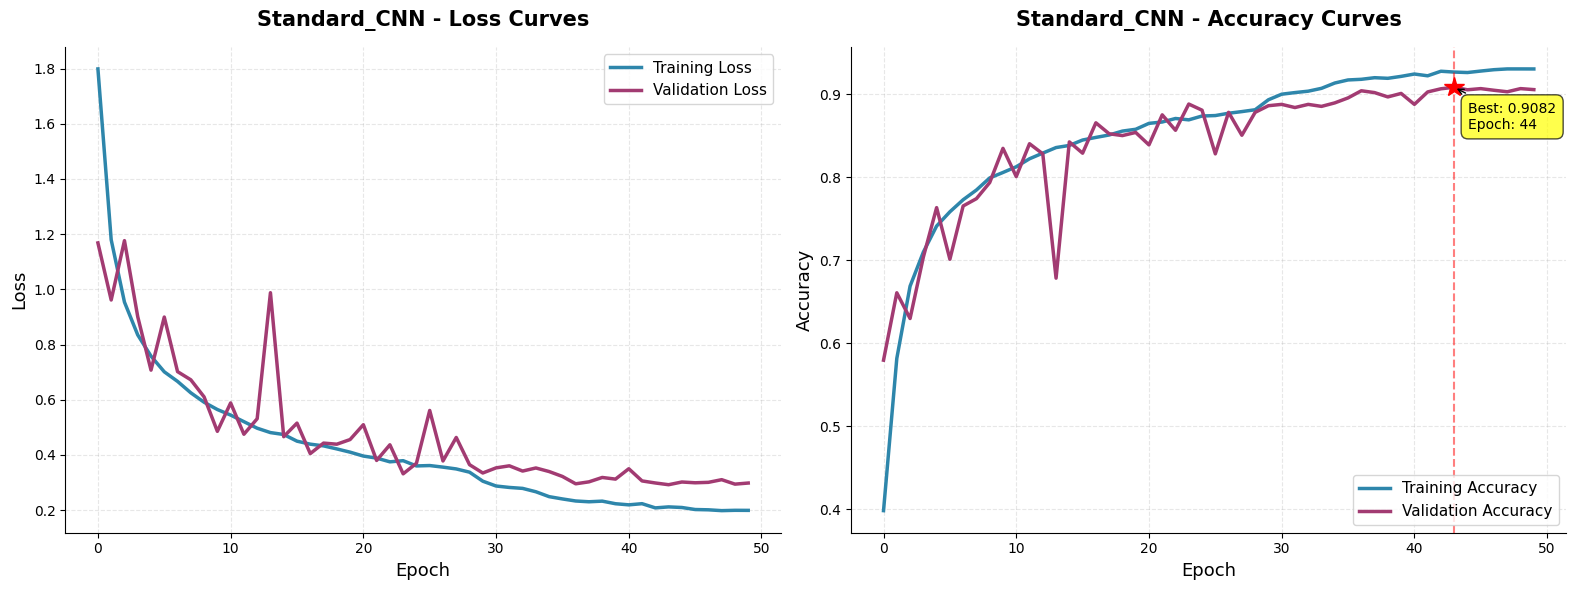

✓ Training curves saved: Standard_CNN_training_curves.png

TRAINING SUMMARY
Total epochs trained: 50
Best validation accuracy: 0.9082 (epoch 44)
Best validation loss: 0.2921 (epoch 44)
Final training accuracy: 0.9303
Final validation accuracy: 0.9054


In [42]:
# ## 12. Plot Training History

# %%
# Extract history
hist = history.history

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss
axes[0].plot(hist['loss'], label='Training Loss', linewidth=2.5, color='#2E86AB')
axes[0].plot(hist['val_loss'], label='Validation Loss', linewidth=2.5, color='#A23B72')
axes[0].set_title(f'{model_name} - Loss Curves', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Loss', fontsize=13)
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: Accuracy
axes[1].plot(hist['accuracy'], label='Training Accuracy', linewidth=2.5, color='#2E86AB')
axes[1].plot(hist['val_accuracy'], label='Validation Accuracy', linewidth=2.5, color='#A23B72')
axes[1].set_title(f'{model_name} - Accuracy Curves', fontsize=15, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Accuracy', fontsize=13)
axes[1].legend(fontsize=11, loc='lower right')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Add best validation accuracy annotation
best_val_acc = max(hist['val_accuracy'])
best_epoch = hist['val_accuracy'].index(best_val_acc)
axes[1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
axes[1].plot(best_epoch, best_val_acc, 'r*', markersize=15)
axes[1].annotate(f'Best: {best_val_acc:.4f}\nEpoch: {best_epoch + 1}',
                xy=(best_epoch, best_val_acc),
                xytext=(10, -30), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig(f'{model_name}_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved: {model_name}_training_curves.png")

# %%
# Training summary
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Total epochs trained: {len(hist['loss'])}")
print(f"Best validation accuracy: {max(hist['val_accuracy']):.4f} (epoch {hist['val_accuracy'].index(max(hist['val_accuracy'])) + 1})")
print(f"Best validation loss: {min(hist['val_loss']):.4f} (epoch {hist['val_loss'].index(min(hist['val_loss'])) + 1})")
print(f"Final training accuracy: {hist['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {hist['val_accuracy'][-1]:.4f}")
print("="*70)

In [44]:
# ## 13. Evaluate on Test Set

# %%
print("\n" + "="*70)
print(f"EVALUATING {model_name} ON TEST SET")
print("="*70 + "\n")

# Evaluate
test_results = model.evaluate(x_test, y_test_cat, verbose=0)
test_loss = test_results[0]
test_acc = test_results[1]
test_top3 = test_results[2]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Top-3 Accuracy: {test_top3:.4f} ({test_top3*100:.2f}%)")

# Get predictions
print("\nGenerating predictions...")
y_pred_probs = model.predict(x_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

print("✓ Predictions generated")





EVALUATING Standard_CNN ON TEST SET

Test Loss: 0.3139
Test Accuracy: 0.9035 (90.35%)
Test Top-3 Accuracy: 0.9848 (98.48%)

Generating predictions...
✓ Predictions generated


In [45]:
# ## 14. Classification Report

# %%
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70 + "\n")

# Generate classification report
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)
print(report)

# Per-class accuracy
print("\n" + "="*70)
print("PER-CLASS ACCURACY")
print("="*70)
for i, class_name in enumerate(class_names):
    mask = y_true_classes == i
    class_acc = np.mean(y_pred_classes[mask] == y_true_classes[mask])
    print(f"{class_name:12s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


CLASSIFICATION REPORT

              precision    recall  f1-score   support

    airplane     0.9398    0.9060    0.9226      1000
  automobile     0.9321    0.9750    0.9531      1000
        bird     0.8971    0.8630    0.8797      1000
         cat     0.8923    0.7290    0.8024      1000
        deer     0.8983    0.9010    0.8997      1000
         dog     0.8906    0.8220    0.8549      1000
        frog     0.8231    0.9770    0.8935      1000
       horse     0.9231    0.9480    0.9354      1000
        ship     0.9476    0.9580    0.9528      1000
       truck     0.9019    0.9560    0.9282      1000

    accuracy                         0.9035     10000
   macro avg     0.9046    0.9035    0.9022     10000
weighted avg     0.9046    0.9035    0.9022     10000


PER-CLASS ACCURACY
airplane    : 0.9060 (90.60%)
automobile  : 0.9750 (97.50%)
bird        : 0.8630 (86.30%)
cat         : 0.7290 (72.90%)
deer        : 0.9010 (90.10%)
dog         : 0.8220 (82.20%)
frog        : 0.9

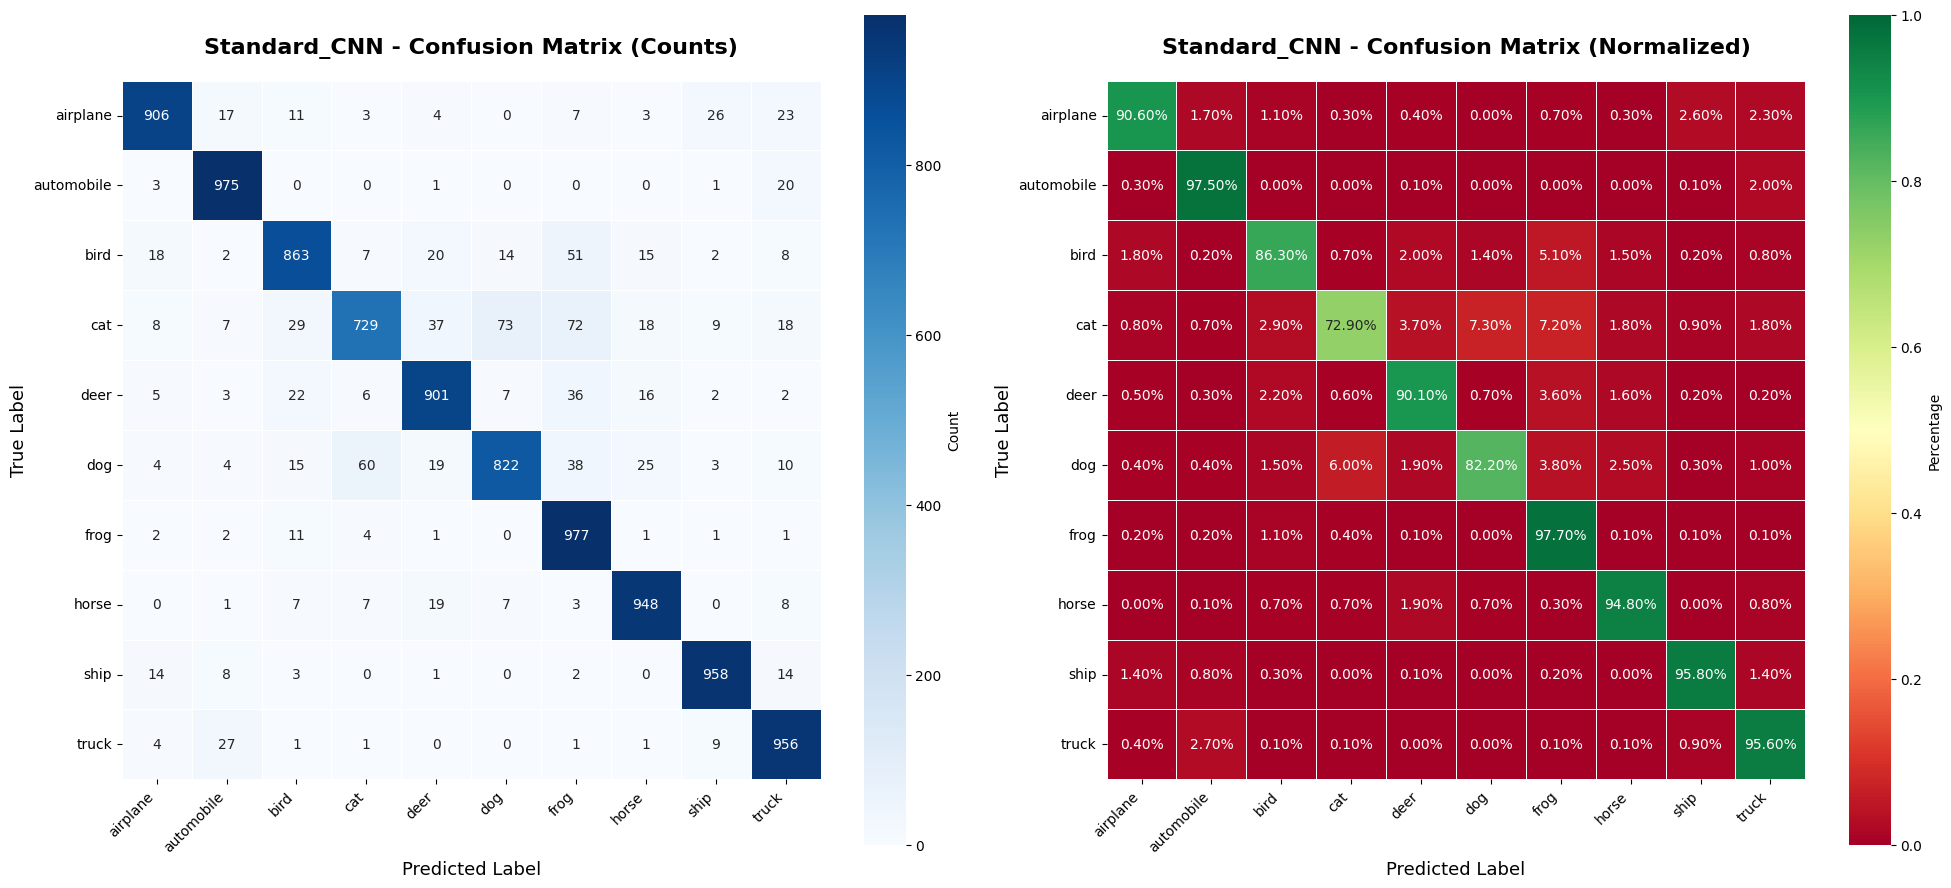

✓ Confusion matrix saved: Standard_CNN_confusion_matrix.png


In [46]:
# ## 15. Confusion Matrix

# %%
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Count'}, ax=axes[0],
           square=True, linewidths=0.5)
axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)',
                 fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Predicted Label', fontsize=13)
axes[0].set_ylabel('True Label', fontsize=13)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Percentage'}, ax=axes[1],
           square=True, linewidths=0.5, vmin=0, vmax=1)
axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)',
                 fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Predicted Label', fontsize=13)
axes[1].set_ylabel('True Label', fontsize=13)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved: {model_name}_confusion_matrix.png")


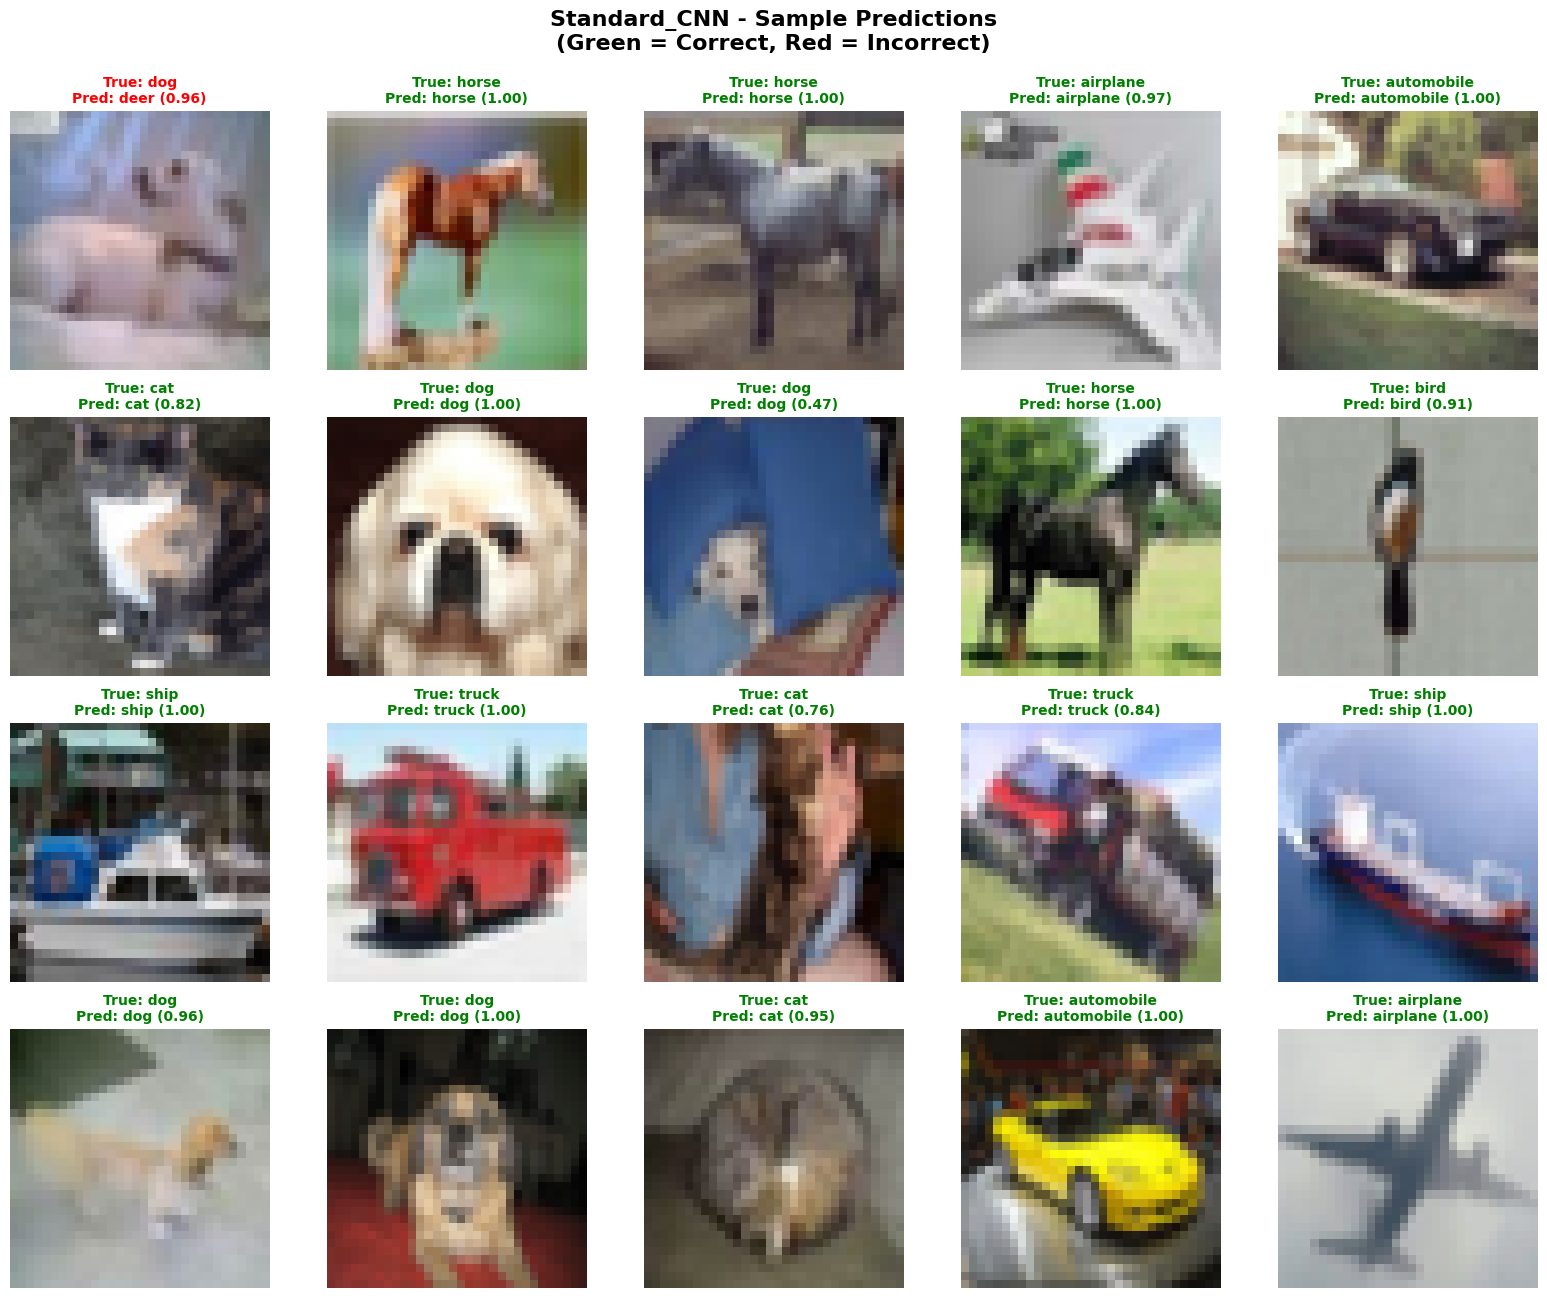

✓ Sample predictions saved: Standard_CNN_sample_predictions.png


In [47]:
# ## 16. Sample Predictions Visualization

# %%
# Select random samples
num_samples = 20
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(16, 13))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    axes[i].imshow(x_test[idx])
    axes[i].axis('off')

    true_label = class_names[y_true_classes[idx]]
    pred_label = class_names[y_pred_classes[idx]]
    pred_prob = y_pred_probs[idx][y_pred_classes[idx]]

    # Color: green if correct, red if wrong
    color = 'green' if y_true_classes[idx] == y_pred_classes[idx] else 'red'

    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})',
                     fontsize=10, color=color, fontweight='bold')

plt.suptitle(f'{model_name} - Sample Predictions\n(Green = Correct, Red = Incorrect)',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{model_name}_sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Sample predictions saved: {model_name}_sample_predictions.png")



Total errors: 965 / 10000 (9.65%)

TOP 10 MOST CONFUSED CLASS PAIRS
 1. cat          → dog         :   73 errors
 2. cat          → frog        :   72 errors
 3. dog          → cat         :   60 errors
 4. bird         → frog        :   51 errors
 5. dog          → frog        :   38 errors
 6. cat          → deer        :   37 errors
 7. deer         → frog        :   36 errors
 8. cat          → bird        :   29 errors
 9. truck        → automobile  :   27 errors
10. airplane     → ship        :   26 errors


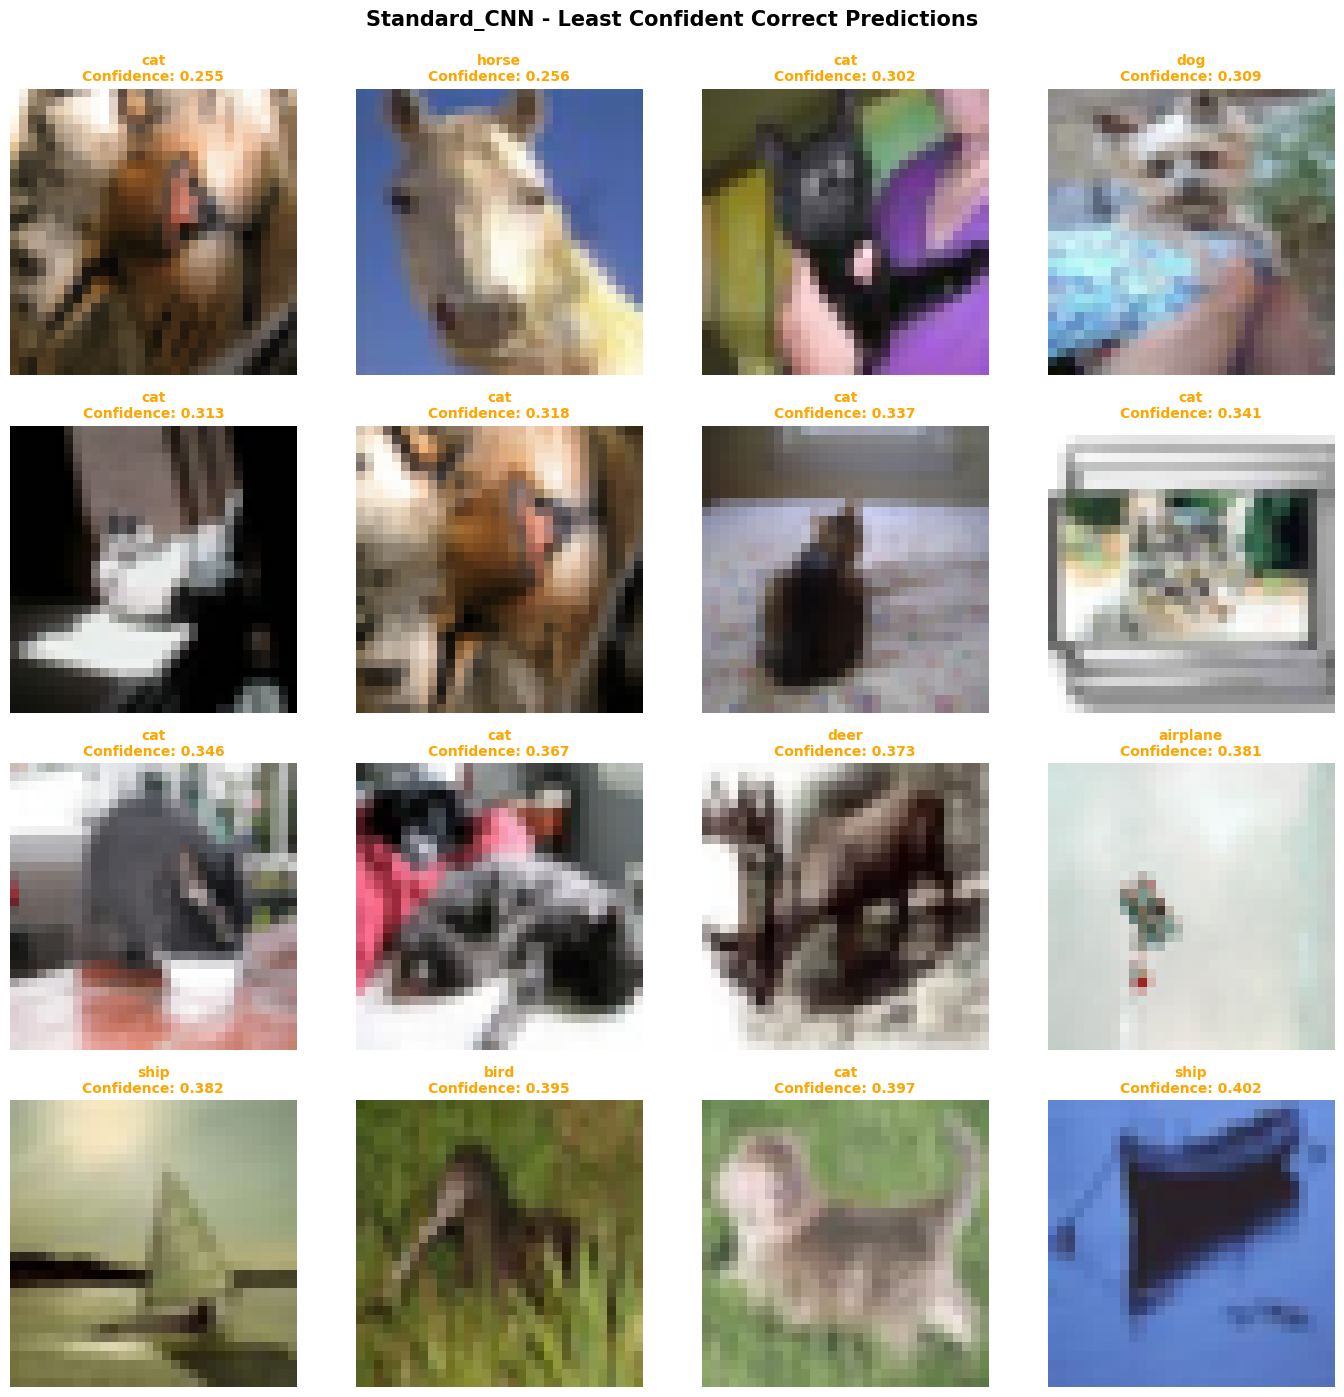

In [48]:
# ## 17. Error Analysis

# %%
# Find incorrect predictions
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]
print(f"\nTotal errors: {len(incorrect_indices)} / {len(y_test)} ({len(incorrect_indices)/len(y_test)*100:.2f}%)")

# Most confused pairs
confusion_pairs = {}
for idx in incorrect_indices:
    true_class = y_true_classes[idx]
    pred_class = y_pred_classes[idx]
    pair = (class_names[true_class], class_names[pred_class])
    confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

# Top 10 confusion pairs
print("\n" + "="*70)
print("TOP 10 MOST CONFUSED CLASS PAIRS")
print("="*70)
sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)[:10]
for i, ((true_cls, pred_cls), count) in enumerate(sorted_pairs, 1):
    print(f"{i:2d}. {true_cls:12s} → {pred_cls:12s}: {count:4d} errors")

# %%
# Visualize worst predictions (lowest confidence correct predictions)
correct_indices = np.where(y_pred_classes == y_true_classes)[0]
correct_probs = np.array([y_pred_probs[i][y_true_classes[i]] for i in correct_indices])
worst_correct_indices = correct_indices[np.argsort(correct_probs)[:16]]

fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.ravel()

for i, idx in enumerate(worst_correct_indices):
    axes[i].imshow(x_test[idx])
    axes[i].axis('off')

    true_label = class_names[y_true_classes[idx]]
    pred_prob = y_pred_probs[idx][y_true_classes[idx]]

    axes[i].set_title(f'{true_label}\nConfidence: {pred_prob:.3f}',
                     fontsize=10, color='orange', fontweight='bold')

plt.suptitle(f'{model_name} - Least Confident Correct Predictions',
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()



In [49]:
# ## 18. Save Results

# %%
# Prepare results dictionary
results = {
    'model_name': model_name,
    'model_type': MODEL_TYPE,
    'training_config': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'optimizer': OPTIMIZER,
        'learning_rate': LEARNING_RATE,
        'use_custom_loss': USE_CUSTOM_LOSS,
        'loss_type': LOSS_TYPE if USE_CUSTOM_LOSS else 'categorical_crossentropy',
        'use_augmentation': USE_AUGMENTATION,
        'use_mixup': USE_MIXUP,
        'use_cutmix': USE_CUTMIX,
        'lr_schedule': LR_SCHEDULE
    },
    'training_history': {
        'loss': [float(x) for x in hist['loss']],
        'accuracy': [float(x) for x in hist['accuracy']],
        'val_loss': [float(x) for x in hist['val_loss']],
        'val_accuracy': [float(x) for x in hist['val_accuracy']]
    },
    'test_results': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'test_top3_accuracy': float(test_top3)
    },
    'best_epoch': int(hist['val_accuracy'].index(max(hist['val_accuracy'])) + 1),
    'best_val_accuracy': float(max(hist['val_accuracy'])),
    'total_epochs_trained': len(hist['loss']),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save to JSON
history_filename = f'{model_name}_training_history.json'
with open(history_filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"✓ Training history saved: {history_filename}")

# Save model
model_filename = f'best_{model_name}.h5'
model.save(model_filename)
print(f"✓ Model saved: {model_filename}")

✓ Training history saved: Standard_CNN_training_history.json
✓ Model saved: best_Standard_CNN.h5


In [50]:
# ## 19. Final Summary

# %%
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nModel: {model_name}")
print(f"Total Parameters: {model.count_params():,}")
print(f"\nTraining:")
print(f"  Epochs trained: {len(hist['loss'])}")
print(f"  Best validation accuracy: {max(hist['val_accuracy']):.4f} (epoch {hist['val_accuracy'].index(max(hist['val_accuracy'])) + 1})")
print(f"\nTest Set Performance:")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Test Top-3 Accuracy: {test_top3:.4f} ({test_top3*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"\nFiles Saved:")
print(f"  ✓ Model: {model_filename}")
print(f"  ✓ History: {history_filename}")
print(f"  ✓ Training curves: {model_name}_training_curves.png")
print(f"  ✓ Confusion matrix: {model_name}_confusion_matrix.png")
print(f"  ✓ Sample predictions: {model_name}_sample_predictions.png")
print("="*70)

# %%
# Download files (for Colab)
if IN_COLAB:
    print("\nDownloading files to local machine...")
    from google.colab import files

    try:
        files.download(model_filename)
        files.download(history_filename)
        files.download(f'{model_name}_training_curves.png')
        files.download(f'{model_name}_confusion_matrix.png')
        files.download(f'{model_name}_sample_predictions.png')
        print("✓ All files downloaded successfully!")
    except:
        print("Note: Run this cell manually to download files")



FINAL SUMMARY

Model: Standard_CNN
Total Parameters: 1,287,754

Training:
  Epochs trained: 50
  Best validation accuracy: 0.9082 (epoch 44)

Test Set Performance:
  Test Accuracy: 0.9035 (90.35%)
  Test Top-3 Accuracy: 0.9848 (98.48%)
  Test Loss: 0.3139

Files Saved:
  ✓ Model: best_Standard_CNN.h5
  ✓ History: Standard_CNN_training_history.json
  ✓ Training curves: Standard_CNN_training_curves.png
  ✓ Confusion matrix: Standard_CNN_confusion_matrix.png
  ✓ Sample predictions: Standard_CNN_sample_predictions.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ All files downloaded successfully!
